# arabic-pretraining-for-urdu-alphabets-recogntion-performace-boost

#### pre-trained on imagenet

#### Author: Zaryab rahman
#### Date:  4/10/25


In [ ]:
!unzip "/content/archive.zip" -d "/content/ahar/"

### Imports

In [19]:
import os
import time
import json
import logging
import torch
import timm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm.auto import tqdm

### Config

In [20]:
CONFIG = {
    "data_path": "/content/ahar",

    "num_classes": 28,
    "batch_size": 64,
    "image_size": 224,
    "num_epochs": 50,
    "learning_rate": 0.001,
    "early_stopping_patience": 5,
    "validation_split": 0.15,

    "checkpoints_dir": "/content/drive/MyDrive/uhar/arabic_pretrained_models/",

    "models_to_evaluate": [
        "swin_tiny_patch4_window7_224",
        "deit_tiny_distilled_patch16_224",
    ]
}

os.makedirs(CONFIG["checkpoints_dir"], exist_ok=True)

### setup device, logging, and directories



In [21]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

#os.makedirs(CONFIG["results_dir"], exist_ok=True)
os.makedirs(CONFIG["checkpoints_dir"], exist_ok=True)

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[
                        logging.FileHandler("experiment_log.log"),
                        logging.StreamHandler()
                    ])

logging.info(f"Using device: {DEVICE}")

### EarlyStopping

In [22]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, checkpoint_path='checkpoint.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.checkpoint_path = checkpoint_path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            logging.info(f'earlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        logging.info(f'validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving best model...')
        torch.save(model.state_dict(), self.checkpoint_path)
        self.val_loss_min = val_loss

### Data Loading and Verification


In [29]:
import os
import time
import json
import logging
import torch
import timm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from torch import nn
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm.auto import tqdm

class ArabicAlphabetDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('.png')]
        # Assuming filenames are in the format 'id_XXXX_label_YY.png'
        self.labels = [int(f.split('_')[-1].split('.')[0]) - 1 for f in self.image_files] # Subtract 1 to make labels 0-indexed

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB') # Convert to RGB to ensure 3 channels
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


def create_arabic_dataloaders(config):
    data_transform = transforms.Compose([
        transforms.Resize((config["image_size"], config["image_size"])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dir = os.path.join(config["data_path"], "train images 13440x32x32", "train")
    test_dir = os.path.join(config["data_path"], "test images 3360x32x32", "test")


    if not os.path.exists(train_dir):
        logging.error(f"Training directory not found at: {train_dir}")
        return None, None, None # Return None for test_loader as well

    # Use the custom dataset
    full_train_dataset = ArabicAlphabetDataset(train_dir, transform=data_transform)
    logging.info(f"Loaded Arabic dataset with {len(set(full_train_dataset.labels))} classes and {len(full_train_dataset)} images.") # Use unique labels for class count

    # Create validation split
    val_split = config["validation_split"]
    dataset_size = len(full_train_dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(val_split * dataset_size))
    np.random.seed(42) # for reproducibility
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(full_train_dataset, batch_size=config["batch_size"], sampler=train_sampler, num_workers=2)
    val_loader = DataLoader(full_train_dataset, batch_size=config["batch_size"], sampler=val_sampler, num_workers=2)

    # Load the test dataset
    test_dataset = None
    test_loader = None
    if os.path.exists(test_dir):
         test_dataset = ArabicAlphabetDataset(test_dir, transform=data_transform)
         test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=2)
         logging.info(f"Test data loader created with {len(test_dataset)} images.")
    else:
        logging.warning(f"Test directory not found at: {test_dir}. Skipping test data loading.")


    logging.info(f"Data loaders created: {len(train_indices)} train images, {len(val_indices)} validation images.")
    return train_loader, val_loader, test_loader # Return test_loader as well

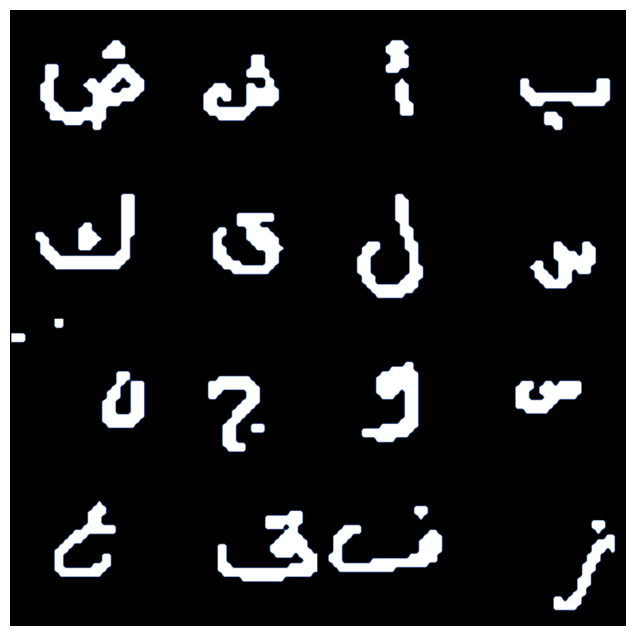

In [34]:
from torchvision.utils import make_grid

train_loader, val_loader, test_loader = create_arabic_dataloaders(CONFIG)

if train_loader:
    images, labels = next(iter(train_loader))

    images = images[:16]
    labels = labels[:16]


    grid = make_grid(images, nrow=4)

    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
else:
    logging.error("training data loader not created.")

### Core Training and Evaluation Functions

In [30]:

def train_model(model, model_name, config, train_dataloader, val_dataloader):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

    # Define the specific path for this model's checkpoint
    best_model_path = os.path.join(config["checkpoints_dir"], f"{model_name}_best_model.pth")
    early_stopper = EarlyStopping(patience=config["early_stopping_patience"], checkpoint_path=best_model_path)

    start_time = time.time()
    for epoch in range(config["num_epochs"]):
        model.train()
        train_loss, train_acc = 0, 0
        train_pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{config['num_epochs']} [Train]", leave=False)
        for X, y in train_pbar:
            X, y = X.to(DEVICE), y.to(DEVICE)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)

        model.eval()
        val_loss, val_acc = 0, 0
        val_pbar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{config['num_epochs']} [Val]", leave=False)
        with torch.no_grad():
            for X, y in val_pbar:
                X, y = X.to(DEVICE), y.to(DEVICE)
                y_pred = model(X)
                val_loss += loss_fn(y_pred, y).item()
                y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                val_acc += (y_pred_class == y).sum().item() / len(y_pred)

        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)

        logging.info(f"Epoch: {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            logging.info("Early stopping triggered.")
            break

    total_time = time.time() - start_time
    logging.info(f"Training completed for {model_name} in {total_time:.2f} seconds.")

### Visualization Functions

In [ ]:
train_loader_arabic, val_loader_arabic, test_loader_arabic = create_arabic_dataloaders(CONFIG)

if train_loader_arabic and val_loader_arabic:
    for model_name in CONFIG["models_to_evaluate"]:
        logging.info(f"\n{'='*80}\nstarting pretrsining for : {model_name}\n{'='*80}")

        model = timm.create_model(
            model_name,
            pretrained=True,
            num_classes=CONFIG["num_classes"]
        ).to(DEVICE)

        train_model(model, model_name, CONFIG, train_loader_arabic, val_loader_arabic)

        logging.info(f"\n{'='*80}\npre-training done for : {model_name}. best weights saved.\n{'='*80}")

    logging.info("pre-training done.")
else:
    logging.error("Could not create Arabic data loaders. Halting pre-training.")

Epoch 1/50 [Train]:   0%|          | 0/179 [00:00<?, ?it/s]